# Climate Change Analysis Belief 2022
© Explore Data Science Academy

_Prepared by:_
- Jessica Njuguna
- Stanley Agbo
- Uchenna Unigwe
- Hunadi Mawela
- Teddy Waweru

## Introduction

### Problem Statement

In the 21st Century, more companies build their brand with the consideration of **lessened environmental impact** or **carbon footprint**. Thus, their operations products and services are inclined to being more **environmentally friendly** and sustainable, in line with their values and ideals. <br>
To improve market research on their products/services, we developed the folowing **ML project** that intends to determine how people **perceive climate change**, and _whether or not they believe it is a real threat_. <br>

We believe this would provide a **metric** on how companies' products/service may be **received by the public**. Providing a robust ML solution will enable our clients to **access to a broad base of consumer sentiment**, spanning multiple demographic and geographic categories - thus **increasing their insights and informing future marketing strategies**.<br>

To build our **predictive model** for the project, we utilized a dataset of **collected tweet data** to determine if a person believes in climate data or _not_.


### Table of Contents

[Introduction](#introduction)
- Problem Statement
- Table of Contents
- Summary
    - Agenda
    - Deliverables
    - Results
    - Future Considerations
- Preliminary Activities
    - Importing Packages
    - Loading the Datasets
    
[Exploratory Data Analysis](#exploratory_data_analysis)
- Functions Declaration
- Statistical Summaries
    - Train Dataset
    - Test Dataset
- Visualizations

[Data Engineering](#data_engineering)
- Functions Declaration
- Dealing with Null Values
- Splitting features
- Dummy Variables
- Data Scaling
- Feature Selection

[Modelling](#modelling)
- Functions Declaration
- RandomForest Classification
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- XG Boost Classification
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- Hyper Parameter Tuning

[Model Performance Comparison](#model_performance_comparison)


[Model Explanation](#model_explanation)

[Conclusion](#conclusion)

[Appendix](#appendix)
- Kaggle Submission
    - Functions Declaration
    - Submission Metrics




    






### _Summary_

**Agenda:**

**Deliverables:**

**Results:**

**Future Considerations:**

### Preliminary Activities

#### Importing Packages

In [1]:
# Libraries for data loading, data manipulation
import pandas as pd
import numpy as np

#Libraries for Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)
from statsmodels.graphics.correlation import plot_corr

#Libraries to clean the text
import contractions #This expands contraction such as 'don't' to 'do not'
import regex as re
import string

# Libraries for data preparation
# import statsmodels.formula.api as sm
# from statsmodels.formula.api import ols
# from scipy.stats import pearsonr
# from statsmodels.distributions.empirical_distribution import ECDF       #Imported for displaying the Empirical Cumulative Distribution of Features
# from sklearn.feature_selection import SelectKBest, f_regression

# Libraries for model building
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.tree import DecisionTreeRegressor

#Libraries for Model Performance
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.tree import plot_tree
# from sklearn.model_selection import GridSearchCV


#Libraries for mathematical analyses
# import numpy as np


#Library for creating pickle files of the models
# import pickle

# Setting global constants to ensure notebook results are reproducible
# PARAMETER_CONSTANT = ###

#### Loading the datasets

In [2]:
raw_train_df = pd.read_csv('resources/data/train.csv')
raw_test_df = pd.read_csv('resources/data/test.csv')

## Exploratory Data Analysis

### Functions Declaration

In [3]:
### We declare the functions that we can call later within the project development

#The function below takes a string and expands all contractions in the string
def expand_contractions(text):
    expanded = contractions.fix(text)
    return expanded

# Function to drop links from text using regex to replace the link with a comma
def strip_links(text):
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

# Function to drop mentions and hashtags from text
def strip_mentions(text):
    strip_sign = ['@']
    for separator in  string.punctuation:
        if separator not in strip_sign :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in strip_sign:
                words.append(word)
    return ' '.join(words)



### Statistical Summaries

#A00 explanation on the type of summaries that we considered for the project

#### Train Dataset

In [4]:
raw_train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


Three columns containing the tweet, the sentiment and the tweetid

In [5]:
raw_train_df.shape

(15819, 3)

In [6]:
raw_train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

The sentiments are imbalanced. We would have to balance the data sets using oversampling in SMOTE.

In [7]:
len(raw_train_df['tweetid'].unique())

15819

In [8]:
raw_train_df.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [9]:
for index,text in enumerate(raw_train_df['message'][30:35]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 @Jnp_Ftw are these the same scientists that denounce climate change? It's not a choice
Review 2:
 RT @Honey17011: A guide to global warming, Paris pact and the US role #DemForce #TheResistance #UniteBlue https://t.co/RYiBLwAJZ4
Review 3:
 RT @latimes: Atmospheric rivers fueled by climate change could decimate wild oysters in San Francisco Bay https://t.co/p0LZBhlU5K https://t…
Review 4:
 Denying climate change ignores basic science
Review 5:
 BGR ~ China practically says Trump lied about climate change https://t.co/Rz37HtcS8d


_Sampling the tweets, we see that some tweets contain url's, some mentions, beginning with @ and some hashtags. These would be cleaned to extract the parts of the tweet that direct us more toward the sentiment_

##### Cleaning the text data

To further explore the data, we will clean the text by performing the following steps:

1. Expand contractions
2. Lower the message
3. Remove URL's
4. Remove mentions
5. Remove digits and words containing digits
6. Remove punctuation

The cleaned tweets will be stored in a new column 'cleaned_message' to manage errors

_1. Expanding contractions_

In [10]:
raw_train_df['cleaned_message']=raw_train_df['message'].apply(lambda x:expand_contractions(x))
raw_train_df['cleaned_message'][0:5]

0    PolySciMajor EPA chief does not think carbon d...
1    It is not like we lack evidence of anthropogen...
2    RT @RawStory: Researchers say we have three ye...
3    #TodayinMaker# WIRED : 2016 was a pivotal year...
4    RT @SoyNovioDeTodas: It is 2016, and a racist,...
Name: cleaned_message, dtype: object

_2. Lowercase all the tweets_

In [11]:
raw_train_df['cleaned_message']=raw_train_df['cleaned_message'].apply(lambda x: x.lower())
raw_train_df['cleaned_message'][0:5]

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt @rawstory: researchers say we have three ye...
3    #todayinmaker# wired : 2016 was a pivotal year...
4    rt @soynoviodetodas: it is 2016, and a racist,...
Name: cleaned_message, dtype: object

_3. Removing URLS_

In [12]:
raw_train_df['cleaned_message']=raw_train_df['cleaned_message'].apply(lambda x:strip_links(x))
raw_train_df['cleaned_message'].head()

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt @rawstory: researchers say we have three ye...
3    #todayinmaker# wired : 2016 was a pivotal year...
4    rt @soynoviodetodas: it is 2016, and a racist,...
Name: cleaned_message, dtype: object

_4. Remove mentions and hashtags_

In [13]:
raw_train_df['cleaned_message']=raw_train_df['cleaned_message'].apply(lambda x:strip_mentions(x))
raw_train_df['cleaned_message'].head()

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt researchers say we have three years to act ...
3    todayinmaker wired 2016 was a pivotal year in ...
4    rt it is 2016 and a racist sexist climate chan...
Name: cleaned_message, dtype: object

In [14]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


#### Test Dataset

In [15]:
raw_test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [16]:
raw_test_df.shape

(10546, 2)

In [17]:
raw_test_df.isna().sum()

message    0
tweetid    0
dtype: int64

In [18]:
len(raw_test_df['tweetid'].unique())

10546

In [19]:
for index,text in enumerate(raw_test_df['message'][30:35]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 How to green the world's deserts and reverse climate change | Allan Savory https://t.co/lYwtQN6ZlQ via @YouTube
Review 2:
 RT @94kristin: let's talk climate change
Review 3:
 RT @mymodernmet: Photographer @thevonwong raises awareness for victims of climate change with epic shoot on a bed of lavaÃ¢â‚¬Â¦
Review 4:
 RT @SteveSGoddard: No matter how much Democrats scream and lie and protest and spread their hatred, the global warming scam will always be…
Review 5:
 RT @TIME: An entire Canadian river vanished due to climate change, researchers say https://t.co/gS6h3j6c9g


### Visualizations

<AxesSubplot:>

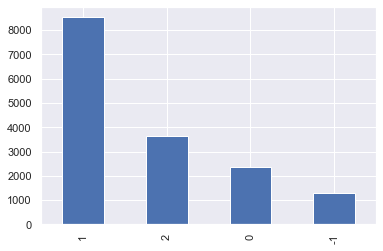

In [20]:
raw_train_df['sentiment'].value_counts().plot(kind = 'bar')

## Data Engineering

### Functions Declaration

### Dealing with Null Values

### Splitting Features

### Dummy Variables

### Data Scaling

### Feature Selection

## Modelling

### Functions Declaration

### RandomForest Classification

#### Model Development

#### Model Performance Metrics

#### Test Dataset Prediction Metrics

### XG Boost Classification

#### Model Development

#### Model Performance Metrics

#### Test Dataset Prediction Metrics

### Hyper Parameter Tuning

## Model Performance Comparison

### Functions Declaration

## Model Explanation

## Conclusion

## Appendix

### Kaggle Submission

#### Functions Declaration

#### Submission Metrics

In [21]:
###